# SD TSIA 210 Challenge

Students : Nicolas Oulianov & Sohaïb Ouzineb

In this challenge, we face with the following task : given two faces and their similarity scores, tell whether these are the same faces or not. This is a binary classification task. 

In this notebook, we highligh how we tackled this problem in order to build a machine learning model,  with a final accuracy of `0.998572761441` on the  validation set. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data importation 

For this challenge, we decided to work with Google Colab to easily iterate on ideas. In order to easily access data from Colab, we put it online, on a Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
X = pd.read_csv('/content/drive/My Drive/sd210 challenge/xtrain_challenge.csv')
y = pd.read_csv('/content/drive/My Drive/sd210 challenge/ytrain_challenge.csv')
X_validation = pd.read_csv('/content/drive/My Drive/sd210 challenge/xtest_challenge.csv')

This data has no missing values and has already been cleaned. This means we can basically use it as it is without further processing.

## Data exploration



### Features description

We know that the first 13 columns correspond to characteristics of face 1, the following 13 to characteristics of face 2, and the last 11 to several similarity scores.

### Data size

We have about 3 times less training samples than validation samples.

In [ ]:
print('Number of training samples :', X.shape[0])
print('Number of validation samples :', X_validation.shape[0])

Number of training samples : 1068504
Number of validation samples : 3318296


### Feature repartition for each class

Looking at the similarity scores boxplots, we see that positive matches (class `1`) have higher scores overall. But there is not a single clear cutoff. This is why so many different similarity scores are needed : one isn't enough. 

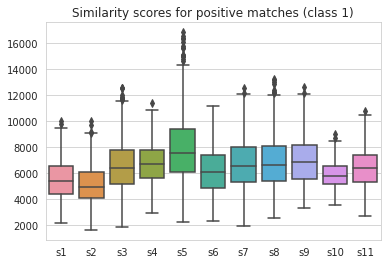

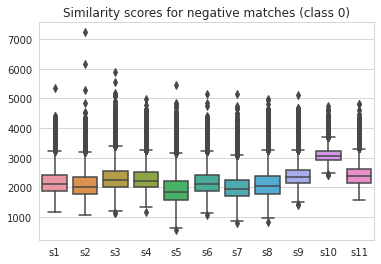

In [ ]:
from random import sample

def conjoint_random_sample(X, y, n_samples):
    """Returns n_samples of X and y randomly, such as to preserve their structure"""
    random_indexes = sample(list(range(0, X.shape[0]-1)), n_samples)
    print()
    return X.iloc[random_indexes,:], y.iloc[random_indexes,:]

# Sample only 10 000 datapoints for this visualization. 
X_sampled, y_sampled = conjoint_random_sample(X, y, 10000)

sns.boxplot(data=X_sampled[y_sampled['y']==1].iloc[:,-11:]) 
plt.title('Similarity scores for positive matches (class 1)')
plt.show()

sns.boxplot(data=X_sampled[y_sampled['y']==0].iloc[:,-11:]) 
plt.title('Similarity scores for negative matches (class 0)')
plt.show()

### Class imbalance

Furthermore, note that the class repartition is heavily imbalanced. More than 96% of the training data are negative matches. This means that a naive model returning the `0` class everytime, regardless of the data, would still get an accuracy of about 96%. 

This is thus our baseline : our classification model needs to score much higher than 96% accuracy. 

This class imbalance has an implication for training. Most binary classifier need, for optimal performance, to have roughly 50% of each class. There are several ways to solve this issue :

- **oversampling** : extend the dataset by duplicating class `1` samples to match the amount of class `0` samples.
- **undersampling** : shrink the dataset by removing class `0` samples to match the amount of class `1` samples.
- **boosting** : by focusing weak learners on wrongly classified data, you make sure not to ignore wrongly classified data from the minority class (class `1`).
- **undersampling and boosting combined** : instead of undersampling once, undersample everytime you build a weak learner during boosting. This means that, overall, more majority class (`0` class) samples will be taken into account than with just undersampling.
- **SMOTE (oversampling)** : create new samples from the minority class by linearly interpolating samples of the minority class. 

In this challenge, we tried several methods. Our final model only uses boosting.


In [ ]:
nb_positive_matches = y[y['y']==1].shape[0]

print("There are {} positive matches among the {} samples dataset ({}% of the data).".format(nb_positive_matches, X.shape[0], round(100*y['y'].mean(), 3)))
print("There are {} negative matches among the {} samples dataset ({}% of the data).".format(X.shape[0] - nb_positive_matches, X.shape[0], round(100*(1-y['y'].mean()), 3)))

There are 39593 positive matches among the 1068504 samples dataset (3.705% of the data).
There are 1028911 negative matches among the 1068504 samples dataset (96.295% of the data).


### 2D space projection

Let's now take a look at the data projected in a lower dimension space. To do so, we use the UMAP algorithm. UMAP groups in the 2D space data that is close together in the n-D space, with respect to the Euclidian distance. It's useful for quick out-of-the-box data visualization. 

On the plotted output, we see that the samples labeled `1` are pretty distinct from the others : they live in some kind of trail. This is good sign: we can make sense of this data. A bad output would have been class `1` and class `0` samples all mixed together. Here, this is not the case, which mean that the task is achievable. 

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


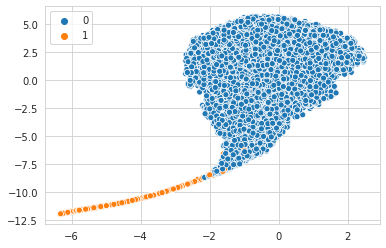

In [ ]:
from umap import UMAP

# Dimension reduction using the UMAP algorithm
dimreduc = UMAP()
X_2d = dimreduc.fit_transform(X_sampled[:,:])

sns.scatterplot(X_2d[:,0], X_2d[:,1], hue=y_sampled.reshape(-1), markers='x')

After this data digging, we're convinced of two things : 

1. The task is achievable. There are some clear differences between classes.
2. The classes are heavily imbalanced. We need to perform some kind of class balancing and use performance metrics relevant to work on imbalanced class data.

## Model selection

### Picking a model family

Based on :

1. The amount of data (roughly 1M)
2. The need for some kind of class balancing
3. A crude benchmark of several classifiers
4. Scientific Literature about SOTA classification models
5. Winning models from Kaggle competitions on similar tasks
6. Hardware and computation speed considerations
7. Our own limitations and knowledge

After testing models from `sklearn` and the [xgboost](https://xgboost.readthedocs.io/en/latest/) library, we saw that ensemble models performed the best. We mainly focused our research based on the xgboost library. 

Indeed, 

1. We ha enough data to use it
2. Boosting takes care of class imbalance
3. Hyperparameter tuning 
4. XGBoost is widely used in industry
5. XGBoost is often a winner in Kaggle classification challenges
6. XGBoost is GPU-accelerated and can leverage Colab infrastructure

Even though xgboost was the final best performing model, we thought it would be fair to report our whole research among several families of model. You'll be able to follow our research in the following. 

### Hyperparameter tuning 

Once a promising model is found, we need to find the best set of hyperparameters. To do that, we compare the cross validation score of the model for various hyperparameters. 

In order to find these hyperparameters, we use a combination of two strategies : random search and grid search. 

We illustrate this search for hyperparameters using a xgboost model.

#### Random Search

We start by broadly scanning the hyperparameter space. We generate random parameters values, and train the model with a fixed amount of random combinations of these parameters. 

At the end, we only keep the best combination. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

random_grid = {'learning_rate': list(np.linspace(0.1, 0.3, num = 3)),
              'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000, 4000],
              'reg_alpha': list(np.linspace(0.0001, 0.01, num = 3)),
              "max_depth": [4, 10, 12, 14, 18]}


In [ ]:
#Random search training
xgbc = XGBClassifier(tree_method='gpu_hist')
xgbc_random = RandomizedSearchCV(estimator=xgbc, n_iter=30, param_distributions = random_grid, 
                          cv = 3, verbose=300, n_jobs = 8, scoring='accuracy')
# Fit the random search model
xgbc_random.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(37,), dtype=object).
Memmapping (shape=(37, 1068504), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_139_221423992/139-139932100575184-f23cd2d738f04eb894b804b684c40f6a.pkl
Pickling array (shape=(37,), dtype=object).
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(1, 1068504), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_221423992/139-139932100575184-aa8cf0413697470683944f42dfb46b8d.pkl
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(712336,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_221423992/139-139932100575184-6a1fe2133b28488c94fc44451026894c.pkl
Memmapping (shape=(356168,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_221423992/139-139932100575184-6648a27da36847099872cd57fecbe23d.pkl
Pickling array (shape=(37,), dtype=object).
M

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           tree_method='gpu_hist',
                                           verbosity=1),
                   iid='deprecated', n_iter=30, n_job

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    predictions = 1*(predictions >= 0.5)
    print('Moyenne des prédictions', predictions.mean())
    errors =  1*(predictions != test_labels)
    errors.astype(float)
    accuracy = 1 - np.mean(errors)
    print('Accuracy = {}'.format(accuracy))
    return accuracy

evaluate(xgbc_random.best_estimator_, X, np.array(y).reshape(-1))
xgbc_random.best_params_

Moyenne des prédictions 0.03705461093266848
Accuracy = 1.0


{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 4000, 'reg_alpha': 0.01}

In [ ]:
y_validation = xgbc_random.best_estimator_.predict(X_validation)
predictions = (y_validation >=0.5)*1
np.savetxt('/content/drive/My Drive/sd210 challenge/outputs/ytest_challenge_student_xgb_random.csv', predictions, fmt = '%1.0d', delimiter=',')

#### Grid Search

After finding a promising set of hyperparameters with random search, we fine-tune even more by looking at the neighborhood of these parameters values. We then try ever combination possible, in order to be sure to have the best one. 

At the end, we only keep the best combination. 

In [ ]:
def refine_params(params, scope):
    new_params = {}
    for k, item in params.items():
        if type(item) == int:
            new_params[k] = [int(item*(1-scope)), item, int(item*(1+scope))]
        elif type(item) == np.float64:
            new_params[k] = [item*(1-scope), item, item*(1+scope)]
    return new_params

refined_params = refine_params(xgbc_random.best_params_, 0.05)
refined_params

{'learning_rate': [0.19, 0.2, 0.21000000000000002],
 'max_depth': [3, 4, 4],
 'n_estimators': [3800, 4000, 4200],
 'reg_alpha': [0.0095, 0.01, 0.0105]}

In [ ]:
refined_params['max_depth'] = [3,4]

In [ ]:
xgbc_grid = GridSearchCV(estimator=xgbc,  param_grid = refined_params, 
                          cv = 3, verbose=300, n_jobs = 8, scoring='accuracy')
xgbc_grid.fit(X, y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(37,), dtype=object).
Memmapping (shape=(37, 1068504), dtype=float64) to new file /dev/shm/joblib_memmapping_folder_139_2561271928/139-139932082103856-efd88cef1648418aba16cecabf9bf356.pkl
Pickling array (shape=(37,), dtype=object).
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(1, 1068504), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_2561271928/139-139932082103856-3288d8f387ce4cb3aa6c9d91a34bffec.pkl
Pickling array (shape=(1,), dtype=object).
Memmapping (shape=(712336,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_2561271928/139-139932082103856-5a8d6cf51197445081e010fbf7f79a2c.pkl
Memmapping (shape=(356168,), dtype=int64) to new file /dev/shm/joblib_memmapping_folder_139_2561271928/139-139932082103856-7ae517f4655346fab31b7b23de4a52eb.pkl
Pickling array (shape=(37,), dtype=objec

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=8,
             param_grid={'learning_rate': [0.19, 0.2, 0.21000000000000002],
                         'max_depth': [3, 4

In [ ]:
evaluate(xgbc_grid.best_estimator_, X, np.array(y).reshape(-1))
xgbc_grid.best_params_

Moyenne des prédictions 0.03705461093266848
Accuracy = 1.0


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 4000, 'reg_alpha': 0.01}

In [ ]:
xgbc_grid.best_estimator_.save_model('best_model_xgbc_0408.json')

In [ ]:
y_validation = xgbc_grid.best_estimator_.predict(X_validation)
predictions = (y_validation >=0.5)*1
np.savetxt('/content/drive/My Drive/sd210 challenge/outputs/ytest_challenge_student_xgb_grid.csv', predictions, fmt = '%1.0d', delimiter=',')

Now, rince and repeat. Do this for a long, very long time, in order to find a good combination of hyperparameters. 

### Looking for a model

For this challenge, we investigated a lot of models. Our attempts included but were not limited to : 

- Random Forests
- Support Vector Machiens (SVM)
- Neural Networks
    - and a certain architecture of neural networks, *siamese networks*


#### Neural Networks

Google Collab provides for a limited amount of time a TPU architecture which is excellent for neural networks since it tremendously speed up the training.

##### Data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=27)

In [ ]:
from sklearn.preprocessing import StandardScaler

qs_labels = ['qs' + str(i+1) for i in range(13)]
qr_labels = ['qs' + str(i+1) for i in range(13)]
s_labels = ['s' + str(i+1) for i in range(11)]

# Normalize the data based on X_train
scale = StandardScaler()

all_X = np.concatenate([X, X_validation], axis=0)  
scale.fit(all_X)

X_norm = scale.transform(X)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
X_validation = scale.transform(X_validation)

##### Architecture of the neural network

Chosing an architecture for a neural network is tricky, and training them is very costly. We chose to cherrypick an architecture that felt suited :

1. For the size of the first layer, a good rule-of-thumb is to use **the mean between number of inputs (37), and number of outputs (1).**
2. Most of the simple tasks can be solved with a **three layers** neural networks. 
3. To avoid overfiting, we added **dropouts**. A dropout layer randomly deactivate 10% (for example) of the layer's neurons during training. It helps training with network regularization.
4. We used **the `relu` activation function** in the network, since it gives state of the art results in several classification task. For the outcome, since we want a probability, we picked `sigmoid`. 

In the following, we describe how we evaluated, then trained this neural network.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# Current best training score : 0.9983... 
def create_model():
      model = Sequential()
      model.add(Dense(20, input_shape=(37,), activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(10, activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(5, activation='relu'))
      model.add(Dropout(0.1))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
      return model

##### TPU Boosting

In neural networks training, speed is key. Here we show of to activate hardware acceleration. 

In [ ]:
# Detect hardware, return appropriate distribution strategy
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    m = create_model()
m.summary()



##### Model Training

In [ ]:
# Train models and evaluate it using cross-validation on StratifiedKFolds

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import optimizers

seed = 7
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, y):
	# Compile model
  with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
  model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=['accuracy'])
  model.fit(X[train], y[train], epochs=100, batch_size=128*300,verbose=False)
	# evaluate the model
  scores = model.evaluate(X[test], y[test], verbose=1)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

#print cvscores
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#99.03% (+/- 1.37%)

##### Train final model

Previously, we trained our model only on a fold of the data. Now, we keep the same architecture, but train it on the whole dataset X. 

This is the final model that will be used to make predictions.


In [ ]:
best_model = model
# We retrain the model on the whole dataset for a few epochs
best_model.fit(X_norm, y, epochs=50, batch_size=512, verbose=True)

##### Predict and Export Data

Finally, we export the results from our best model. 


In [ ]:
predictions = best_model.predict(X_validation)
# Predictions are between 0 and 1. Make those above 0.5 ones, and those under zeros.
predictions = (predictions >= 0.5)*1
# Save file
np.savetxt('ytest_challenge_student.csv', predictions, fmt = '%1.0d', delimiter=',')

### Siamese Neural Networks 

Previously, we showed a classic neural network architecture. But more complex architectures may also be used, for example **siamese neural networks**.

The idea of the siamese neural network is to train a neural network $N$ on
the first image $a_1$ and the second image $a_2$ in parallel. We take the outputs $N(a_1) = v_1$ and $N(a_2) = v_2$. The prediction is finally made by applying a simoid to $|v_1 - v_2|_1$ 

![alt text](https://image.noelshack.com/fichiers/2020/17/1/1587405033-94141351-949209888830378-5461321401019400192-n.png)

*Illustration used with the courtesy of MIT.edu*

Even though this idea was not fully successfull, we felt that this architecture was suited for our problem if we had more image data.

In [ ]:
#Setup ...
!pip install -U tf-nightly

In [ ]:
%tensorflow_version 2.x
import re, sys, time
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
import tensorflow as tf
import re, sys, time
import keras

from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, BatchNormalization, Activation
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam

print("Tensorflow version " + tf.__version__)
tf.compat.v1.disable_eager_execution()

#### Model Building

In [ ]:
def create_model():
    """
        Model architecture
    """
    # defines a loop-less NN architecture

    # Define the tensors for the two input images
    left_input = Input(shape=(13,)) #Input_left(input_shape)
    right_input = Input(shape=(13,))#Input_right(input_shape)
    model = Sequential()
    model.add(Dense(30, input_shape=(13,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    optimizer = Adam(0.01)
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    siamese_net.compile(
        optimizer=optimizer,
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )  
    
    return siamese_net

#### Model fitting

The model is finally train as a usual neural network. This architecture, however, is more suited for raw image data and sadly the performance was not up to par. Our best score was about 98% accuracy. 

In [ ]:
siamese_net.fit([X[:,0:13],X[:,13:26]], y, #train only on the 2 images
          batch_size=128*100,
          epochs=1000,
          verbose=1,)

### Automatic hyperparameter tuning with h2o

The task of searching ofr hyperparameters, that we depicted in the previous part, is pretty tedious and repetitive.

There actually exist frameworks to automate hyperparameter search and models benchmarking, such as [h2o](https://www.h2o.ai). This is what we used to further improve our model search. 

Basically, h2o autoML performs the hyperparameter search the same way we did before. But it also combines all of the best models in a stacked fashion. We will talk more stacking in the next part.

#### Installing h2o

In [ ]:
# Start by installing some packages on Colab
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip uninstall h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 129.5MB 24kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.1-py2.py3-none-any.whl size=129557718 sha256=15c339121c5068e2ea024c20f21a02b1c43a5ffe906a55fa8e7d0a7030f5dd55
  Stored in directory: /root/.cache/pip/wheels/db/42/63/d118d7218432054da842f5d10bd4f99e978bde0931164e6c7a
Successfully built h2o


#### Importing data

h2o use its own dataframe format. We need to reload the data.

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(max_mem_size=8)

X_h2o = h2o.import_file('/content/drive/My Drive/sd210 challenge/xtrain_challenge.csv')
Y_h2o = h2o.import_file('/content/drive/My Drive/sd210 challenge/ytrain_challenge.csv')
X_validation_h2o = h2o.import_file('/content/drive/My Drive/sd210 challenge/xtest_challenge.csv')
full_data = X_h2o.cbind(Y_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 mins 19 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_7lciy9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.413 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Training

For h2o automl to train, you need to specifiy a maximum runtine. Below, the algorithm trained for about one hour. But we ran it up to 48 hours during other tests.

##### What performance metric to chose ?

How to compare one model to another ? Just picking accuracy isn't enough because we have heavily imbalance classes. Accuracy also doesn't tell us anything about false positives and false negatives rates. 

That's why we used during testing other metrics to compare one model to another :
- Either, the **Cohen-Kappa score**. It can be defined a normalized version of accuracy, that takes into account the repartition of classes.
- Either, the **F1 score**. It's the geometric mean between precision and recall. It's a way to equally take into account these two important metrics. Precision measures how sure we are that the 1 we predict are actually 1. Recall makes sure we don't miss any 1 to predict. 

$$ F1_{score} = 2\frac{precision * recall}{precision + recall} $$

With

$$ precision = \frac{TP}{TP + FP} $$

$$ recall = \frac{TP}{TP + FN} $$

- Either, the **PR AUC score**, that is the aera under the precision / recall curve as measured for various values of the probability threshold. It's thus similar to the F1 score, but more focused on the minority class. The closer to 1, the better. 

In this challenge, we chose to use the **PR AUC score** when ranking models against one another.  



In [ ]:
# For binary classification, response should be a factor
full_data['y'] = full_data['y'].asfactor()

In [ ]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(seed=1234, verbosity="info", stopping_tolerance=0.0001, max_runtime_secs=3600, exclude_algos=["DRF", "GLM", "GBM", "DeepLearning"], 
                stopping_metric='AUC PR', sort_metric='AUC PR') # Chose AUC PR as a sorting and stopping metric
aml.train(x=list(X_h2o.columns), y='y', training_frame=full_data)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))  # Print all rows instead of default (10 rows)

# The leader model is stored here
best_model = aml.leader

AutoML progress: |
12:53:45.566: Project: AutoML_20200408_125345566
12:53:45.566: Stopping tolerance set by the user: 1.0E-4
12:53:45.568: Stopping tolerance set by the user is < 70% of the recommended default of 0.001, so models may take a long time to converge or may not converge at all.
12:53:45.568: Build control seed: 1234
12:53:45.569: training frame: Frame key: automl_training_py_184_sid_aaf5    cols: 38    rows: 1068504  chunks: 16    size: 89291028  checksum: -8841141387549122718
12:53:45.569: validation frame: NULL
12:53:45.569: leaderboard frame: NULL
12:53:45.569: blending frame: NULL
12:53:45.569: response column: y
12:53:45.569: fold column: null
12:53:45.569: weights column: null
12:53:45.569: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
12

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20200408_125345,0.999812,0.00377025,0.997635,0.00964976,0.0308578,0.000952202
XGBoost_1_AutoML_20200408_125345,0.999806,0.00374797,0.997726,0.0094817,0.0305952,0.000936066
XGBoost_grid__1_AutoML_20200408_125345_model_2,0.999793,0.00374056,0.997668,0.0103982,0.030331,0.000919971
XGBoost_grid__1_AutoML_20200408_125345_model_1,0.999782,0.00362353,0.998016,0.00875555,0.029655,0.000879421
StackedEnsemble_AllModels_AutoML_20200408_125345,0.999448,0.00525995,0.997582,0.0093549,0.0311601,0.000970954
XGBoost_grid__1_AutoML_20200408_125345_model_3,0.999288,0.00958934,0.996571,0.0118709,0.0341188,0.00116409
XGBoost_2_AutoML_20200408_125345,0.999041,0.0146054,0.995604,0.0132902,0.0372004,0.00138387


In [ ]:
preds = aml.leader.predict(X_validation_h2o)
predictions = (preds >=0.5)*1

# Export results to csv
h2o.export_file(
  predictions["p1"],
  "AUTOML_exportfile_H20.csv",
  force = True,
  sep = ",",
  parts = 1
)

# To erase header line
with open("AUTOML_exportfile_H20.csv",'r') as f:
    with open("updated_AUTO_ML_test.csv",'w') as f1:
        next(f) # skip header line
        for line in f:
            f1.write(line)

## Stacking models

Previously, we showed how to pick the best hyperparameters for a model through random search, grid search and automatic hyperparameter tuning. We also explored several families of models: boosted trees, neural networks, siamese networks...

But we can go further using **stacking**. The idea stacking is to combine several strong learners, that we trained in the previous part, into a super learner.

To do that, the basic method is to create a new feature matrix $X'$, where each column is the prediction of a model. Then, build a *stacked* model that takes this new matrix $X'$ as an input, and predict the dependent variable $y$. 

The metal-model uses a standard machine-learning algorithm (for example, linear regresion) to make its predictions.

Below, we show how we build a stacked model. 

In [ ]:
# We'll use these function for model evaluation
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

In [ ]:
#Create arrays for the models
Y_train = y.values.ravel()
X_train = X.values
X_test = X_validation.values 

#Set parameters for ensembling
ntrain = X_train.shape[0]
ntest = x_test.shape[0]
seed = 10
nfolds = 4
kf = KFold(n_splits = nfolds, random_state = seed)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
# To pipe our stacked model, we need this handler
class SklearnHandler(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    

#### Out of fold predictions

Stacking uses predictions of base classifiers as input for training to a second-level model.

However, if we train the base models on the full training data, compute predictions on the full test set and then output these for the second-level training, there is an issue. Indeed, the base model predictions have already "seen" the test set. There's risk for overfitting.

To deal with this tricky issue, we perform out-of-fold predictions. This is a technique were we store the base models' predictions of every fold of the training data. Then, we compute the mean of these predictions. This latter will be the input for the metalearner model. It should be less prone to overfit. 

In [ ]:
#Funtion to get out-of-fold predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1, 1)

### Build base models

For random forest, we use the `balanced` value for `class_weight` parameter. It uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. This is useful since we have imbalanced data.

In [ ]:
#Create parameters for all classifiers

#Random Forest parameters
rf_params = {
    'n_estimators':10,
    'class_weight':"balanced",
    'n_jobs': -1, 'verbose':2}

#Gradient Boosting parameters
xgb_params = {
    'three_method': 'gpu-hist'}

#neural-networks parameters
mlp_params = {}

#basic naive bayes parameters
nb_params = {}

In [ ]:
#Create base models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

rf = SklearnHandler(clf=RandomForestClassifier, seed=seed, params=rf_params)
xgb = SklearnHandler(clf=XGBClassifier, seed=seed, params=xgb_params)
mlp = SklearnHandler(clf=MLPClassifier, seed=seed, params=mlp_params)
nb = SklearnHandler(clf=GaussianNB, params=nb_params)

In [ ]:
#Create our OOF train and test predictions. These base results will be used as new features

rf_oof_train, rf_oof_test = get_oof(rf, X_train, Y_train, X_test) # Random Forest
print("rf-done")
xgb_oof_train, xgb_oof_test = get_oof(xgb, X_train, Y_train, X_test) # Gradient Boost
print("xgb-done")
mlp_oof_train, mlp_oof_test = get_oof(mlp, X_train, Y_train, X_test) # Support Vector Classifier
print("mlp-done")
nb_oof_train, nb_oof_test = get_oof(nb, X_train, Y_train, X_test) # Support Vector Classifier
print("nb-done")
print("Training is complete")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10building tree 3 of 10

building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.8s finished


rf-done
xgb-done
mlp-done
nb-done
Training is complete


Text(0.5, 1.0, 'feature correlations')

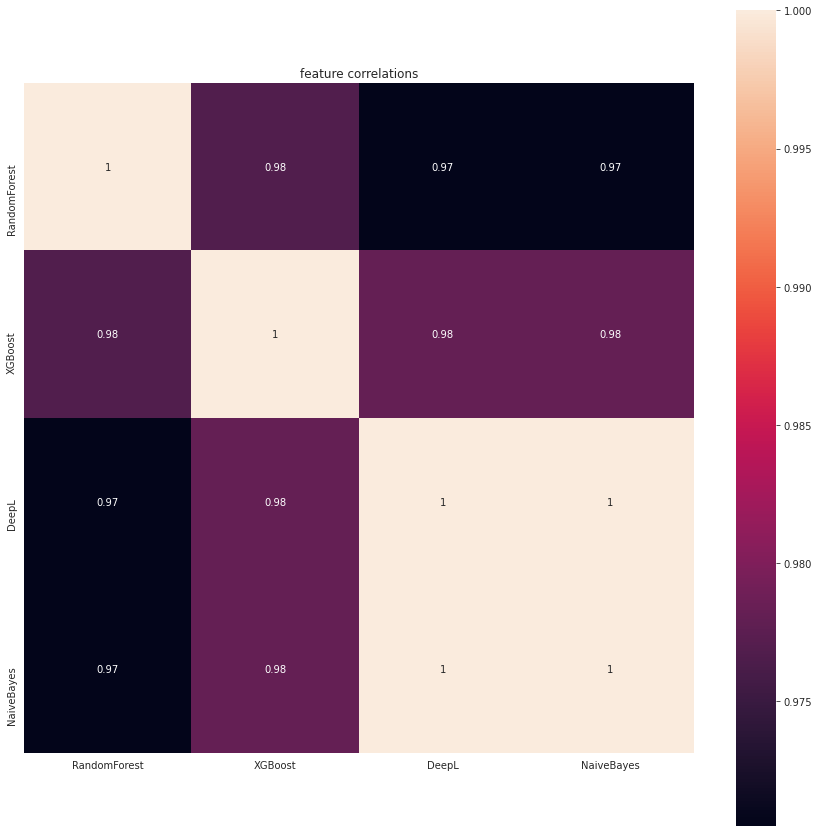

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'XGBoost': xgb_oof_train.ravel(),
     'DeepL': mlp_oof_train.ravel(),
     'NaiveBayes': mlp_oof_train.ravel()})

corr = base_predictions_train.astype(float).corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, vmax=1, annot=True, square=True)
plt.title('feature correlations')

# We want the models to be the least correlated as possible.

### Build the meta learner

We use xgboost as a model for the metal learner. 

In [ ]:
#prepare data for meta learning
# This is our "big matrix" X' containing all the base models predictions
X_train = np.concatenate((rf_oof_train, xgb_oof_train, mlp_oof_train, nb_oof_train), axis=1)
X_test = np.concatenate((rf_oof_test, xgb_oof_test, mlp_oof_test, nb_oof_test), axis=1)

In [ ]:
# We train the metalearner
gbm = XGBClassifier(three_method= 'gpu-hist').fit(X_train, Y_train)
predictions = gbm.predict(X_test)

In [ ]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({'y': predictions })
StackingSubmission.to_csv("pd_StackingSubmission.csv", index=False, header=False)

This is, of course, only a dummy example. But we ran a similar stacked on many more models. As we're writing this report, some of these are still in training. One of them, that includes random forest, SVM, neural networks and xgboost, stacked in a logistic regression, is quite promising. 

## Our best model

After all this search, we found one best model, which hyperparameters are provided below. 

In [ ]:
from xgboost import XGBClassifier

best_params = {'subsample': 0.9437946990561346, 
 'reg_alpha': 0.02, 
 'n_estimators': 2637, 
 'max_depth': 5, 
 'learning_rate': 0.06381610719200868, 
 'colsample_bytree': 0.8657967835105694}


xgbc = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, **best_params)
xgbc.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8657967835105694, gamma=0,
              learning_rate=0.06381610719200868, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=2637, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.02, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9437946990561346, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
y_validation = xgbc.predict_proba(X_validation)[:,1]
y_pred = xgbc.predict_proba(X)

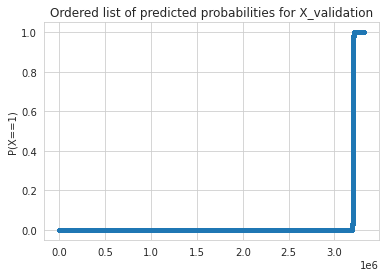

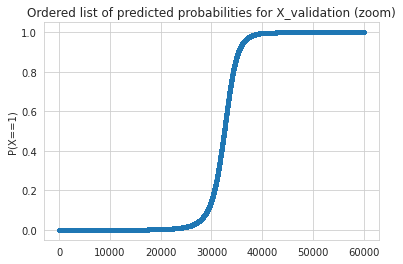

In [ ]:
# Plot the validation results
plt.plot(np.sort(y_validation), '.')
plt.title('Ordered list of predicted probabilities for X_validation')
plt.ylabel('P(X==1)')
plt.show()

# Zoom on the S. The sharper the S, the better are the results. 
plt.plot(np.sort(y_validation)[3170000:3230000], '.')
plt.title('Ordered list of predicted probabilities for X_validation (zoom)')
plt.ylabel('P(X==1)')
plt.show()

In [ ]:
# Export predictions
predictions = (y_validation >=0.5)*1 
np.savetxt('/content/drive/My Drive/sd210 challenge/outputs/ytest_challenge_student_xgbc_best.csv', predictions, fmt = '%1.0d', delimiter=',')

Our validation score on this one was `0.998564926095`. Our next strategy was to try different probability thresholds. We found that the threshold of 0.49 was slightly better. 


In [ ]:
preds=np.array(bagg.predict_proba(xtest))
preds_np=(preds>0.49)*1  
np.savetxt('bagg_04.csv', preds_np, fmt = '%1.0d', delimiter=',')
preds_np=(preds>0.51)*1

## Conclusion

Our final best score on the validation set was `0.998572761441`. It was obtained with a single well-tuned xgboost model.

Apart from the performance, what did we take away from this project ?

1. Patience is key. Model training and testing ideas takes a lot of time.  

2. Simple models already work very well. In our case, a single xgboost manualy tuned was better than 50 models automatically generated by h2o and then combined into a stacked model. 

3. Adaptability. In practice, machine learning asks you to jungle between a lot of mathematical, statistical and computer science concepts, with which we were little familiar. 

Overall, this was a rich learning experience. We got really hands-on experience and we are proud of the final performance of our model. 